<a href="https://colab.research.google.com/github/GerardoFesta/3DFER_SE4AI/blob/main/models/2DModels/LandmarkCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, unzip

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


If you don't use MLFLOW, don't run it

```
# Questo è formattato come codice
```



In [ ]:
!pip install -q mlflow
!databricks configure --host https://community.cloud.databricks.com/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
Username: gfesta24@gmail.com
Password: 
Repeat for confirmation: 


In [ ]:

import sys
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import numpy as np

# Data Loading

Change the path if you have a different location. Data are extracted with LandmarkExtraction, in 3DTransformations

In [ ]:
train_df = pd.read_csv("/content/drive/Shareddrives/Datasets SEFAI/training_set.csv")
test_df = pd.read_csv("/content/drive/Shareddrives/Datasets SEFAI/test_set.csv")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Questo commento serve per provare il funzionamento dei commit con colab

batch_size = 64

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X_array, Y_array, transform=None):
        self.X = X_array
        self.Y = Y_array
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        label = self.Y[index]

        # Esegui le trasformazioni se definite
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:

test_df['landmarks'] = test_df['landmarks'].apply(lambda lab: eval(lab))

train_df['landmarks'] = train_df['landmarks'].apply(lambda lab: eval(lab))
print(train_df)

                                      nome  \
0        train/angry/Training_12391352.jpg   
1        train/angry/Training_52407046.jpg   
2        train/angry/Training_20666200.jpg   
3        train/angry/Training_11533347.jpg   
4        train/angry/Training_60003551.jpg   
...                                    ...   
26700  train/disgust/Training_63164084.jpg   
26701  train/disgust/Training_25610374.jpg   
26702  train/disgust/Training_67023235.jpg   
26703  train/disgust/Training_61032772.jpg   
26704  train/disgust/Training_96306068.jpg   

                                               landmarks    label  
0      [[0.5751925706863403, 0.5731657147407532, -0.1...    angry  
1      [[0.43962034583091736, 0.7553703784942627, -0....    angry  
2      [[0.6029075384140015, 0.5643556118011475, -0.0...    angry  
3      [[0.5550940036773682, 0.7429446578025818, -0.0...    angry  
4      [[0.5235995054244995, 0.8211154937744141, -0.0...    angry  
...                                    

In [ ]:
print(type(train_df.at[0,"landmarks"]))

label_dict = {"angry":0, "sad": 1, "neutral": 2, "surprise": 3, "disgust": 4, "fear": 5, "happy": 6}

test_df['label'] = test_df['label'].apply(lambda lab: label_dict[lab])

train_df['label'] = train_df['label'].apply(lambda lab: label_dict[lab])

array_train = train_df['landmarks'].to_numpy()
X_train = np.stack([np.array(lst) for lst in array_train])
y_train = train_df['label'].to_numpy()
array_test = test_df['landmarks'].to_numpy()
X_test = np.stack([np.array(lst) for lst in array_test])
y_test = test_df['label'].to_numpy()

Using SMOTE to oversample

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto')
original_shape = X_train.shape
arr = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
print(arr.shape)
X_train, y_train = smote.fit_resample(arr, y_train)
X_train = np.reshape(X_train, (X_train.shape[0],478,3) )
print(X_train.shape, y_train.shape)

(26705, 1434)
(48636, 478, 3) (48636,)


In [ ]:
train_dataset = CustomDataset(X_train, y_train, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = CustomDataset(X_test, y_test, transform=transforms.ToTensor())

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print( X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(48636, 478, 3) (48636,) (6678, 478, 3) (6678,)


# Model

In [ ]:
def accuracy(preds, labels):
  probabilities = torch.nn.functional.softmax(preds, dim=1)
  _, predicted = torch.max(probabilities, dim=1)
  n_correct = (predicted==labels).sum().float()

  acc =n_correct / labels.shape[0]
  acc= torch.round(acc*100)
  return acc, n_correct;

In [ ]:


class LandmarkCNN(nn.Module):
    def __init__(self):
        super(LandmarkCNN, self).__init__()

        self.conv1 = nn.Conv1d(3, 32, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn1 = nn.BatchNorm1d(32, dtype=torch.float64)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn2 = nn.BatchNorm1d(64, dtype=torch.float64)

        self.pool = nn.MaxPool1d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn3 = nn.BatchNorm1d(128, dtype=torch.float64)

        self.conv4 = nn.Conv1d(128, 128, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn4 = nn.BatchNorm1d(128, dtype=torch.float64)

        self.dropout2 = nn.Dropout(0.25)

        self.conv5 = nn.Conv1d(128, 256, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn5 = nn.BatchNorm1d(256, dtype=torch.float64)

        self.conv6 = nn.Conv1d(256, 256, kernel_size=3, padding=1, dtype=torch.float64)
        self.bn6 = nn.BatchNorm1d(256, dtype=torch.float64)

        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * 59, 256, dtype=torch.float64)
        self.bn7 = nn.BatchNorm1d(256, dtype=torch.float64)

        self.dropout4 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 7, dtype=torch.float64)

    def forward(self, x):
        x = x.view(-1, 3, 478)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.LeakyReLU()(x)

        x = self.pool(x)

        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.LeakyReLU()(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = nn.LeakyReLU()(x)

        x = self.pool(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = nn.LeakyReLU()(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = nn.LeakyReLU()(x)

        x = self.pool(x)
        x = self.dropout3(x)
        x=x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.bn7(x)
        x = nn.LeakyReLU()(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

# Training Loop

MlFlow logging inplace, so, if you don't use it, comment when needed

In [ ]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/gfesta24@gmail.com/SMOTHE-LandmarkCNN")



In [ ]:
param_grid = {'batch_size': [64, 128, 256, 512],'lr': [0.0001, 0.001], "decay":[0, 0.001, 0.01]}
expanded_grid = ParameterGrid(param_grid)
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("/Users/gfesta24@gmail.com/SMOTHE-LandmarkCNN")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in range(len(expanded_grid)):

  runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id], filter_string=" and ".join([f"params.{k} = '{v}'" for k, v in expanded_grid[i].items()]))
  if not len(runs) == 0:
    print("RUN: ", [f"params.{k} = '{v}'" for k, v in expanded_grid[i].items()], " già completata" )
  else:
    train_loader = DataLoader(train_dataset, batch_size=expanded_grid[i]['batch_size'], shuffle=True)

    test_loader = DataLoader(test_dataset, batch_size=expanded_grid[i]['batch_size'], shuffle=False)


    model = LandmarkCNN()
    optimizer = optim.Adam(model.parameters(), lr=expanded_grid[i]['lr'], weight_decay=expanded_grid[i]['decay'])
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    mlflow.start_run()

    mlflow.set_tag("model_name", "LandmarkCNN")
    mlflow.log_param("lr", expanded_grid[i]['lr'])
    mlflow.log_param("batch_size", expanded_grid[i]['batch_size'])
    mlflow.log_param("decay", expanded_grid[i]['decay'])


    patience = 3

    acc_list_train=[]
    acc_list_test=[]


    n_total_steps = len(train_loader)


    best_loss = 100
    counter=0
    stop=False
    num_epochs = 100
    for epoch in range(num_epochs):
            model.train()
            print(counter)
            if stop:
              print(stop)
              break
            running_loss = 0.0
            running_acc = 0
            seen = 0
            for images, labels in train_loader:

              images = images.to(device)
              labels = labels.to(device)


              outputs = model(images)

              loss = criterion(outputs, labels)

              _, acc = accuracy(outputs, labels)
              seen +=labels.shape[0]

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              running_loss += loss.item()
              running_acc += acc

            print (f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Acc: {running_acc/seen:.4f}')
            acc_list_train.append(running_acc/len(train_loader))
            mlflow.log_metric("train_loss", running_loss / len(train_loader), step=epoch)
            mlflow.log_metric("train_acc", running_acc/seen, step=epoch)
            model.eval()

            tot_corrette = 0
            tot_eseguite = 0
            running_test_loss = 0
            val_loss = 0

            with torch.no_grad():

              for images, labels in test_loader:
                  images = images.to(device)
                  labels = labels.to(device)

                  outputs = model(images)
                  test_loss = criterion(outputs, labels)
                  _, n_corrette=accuracy(outputs, labels)

                  running_test_loss += test_loss.item()
                  tot_corrette+=n_corrette.item()
                  tot_eseguite+=labels.shape[0]

              test_acc=100* (tot_corrette/tot_eseguite)
              val_loss = running_test_loss / len(test_loader)
              acc_list_test.append(test_acc)
              print("Test acc: ", test_acc)
              print("Test loss: ", val_loss)
              mlflow.log_metric("test_acc", test_acc, step=epoch)
              mlflow.log_metric("test_loss", val_loss, step=epoch)


            if val_loss < best_loss:
              print("MIGLIORATO")
              torch.save(model.state_dict(), 'model_weights.pth')
              best_loss = val_loss
              best_model_train_acc=running_acc/seen
              best_model_test_acc=test_acc
              best_model_test_loss=val_loss
              best_model_train_loss=running_loss / len(train_loader)
              counter = 0
              # Salva i pesi del modello se la validation loss è migliorata
              torch.save(model.state_dict(), 'best_model.pt')
            else:
              counter += 1
            # Verifica se raggiunto il criterio di early stopping
              if counter >= patience:
                  print(f'Early stopping at epoch {epoch+1}')
                  mlflow.set_tag("Epochs_stopped", epoch+1)
                  mlflow.log_artifact("best_model.pt")
                  mlflow.log_metric("best_test_acc", best_model_test_acc)
                  mlflow.log_metric("best_test_loss", best_model_test_loss)
                  mlflow.log_metric("best_train_acc", best_model_train_acc)
                  mlflow.log_metric("best_train_loss", best_model_train_loss)
                  mlflow.end_run()
                  stop=True
            print("BEST TEST LOSS: ", best_loss)


0
Epoch [0/100], Loss: 1.6246, Acc: 0.3658
Test acc:  42.6325247079964
Test loss:  1.4713154708610927
MIGLIORATO
BEST TEST LOSS:  1.4713154708610927
0
Epoch [1/100], Loss: 1.4514, Acc: 0.4400
Test acc:  45.073375262054505
Test loss:  1.4301441394671384
MIGLIORATO
BEST TEST LOSS:  1.4301441394671384
0
Epoch [2/100], Loss: 1.3937, Acc: 0.4655
Test acc:  49.19137466307278
Test loss:  1.3066131189038483
MIGLIORATO
BEST TEST LOSS:  1.3066131189038483
0
Epoch [3/100], Loss: 1.3493, Acc: 0.4844
Test acc:  47.903563941299794
Test loss:  1.3866183396890062
BEST TEST LOSS:  1.3066131189038483
1
Epoch [4/100], Loss: 1.3162, Acc: 0.4976
Test acc:  49.77538185085355
Test loss:  1.3014717026658613
MIGLIORATO
BEST TEST LOSS:  1.3014717026658613
0
Epoch [5/100], Loss: 1.2882, Acc: 0.5076
Test acc:  50.41928721174004
Test loss:  1.2824619879904362
MIGLIORATO
BEST TEST LOSS:  1.2824619879904362
0
Epoch [6/100], Loss: 1.2683, Acc: 0.5133
Test acc:  51.81191973644804
Test loss:  1.2460607501843823
MIGLIOR

# TESTING

This code is needed to get the best model from MLFLOW

In [ ]:
def get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name):
    runs = mlflow.search_runs(experiment_ids=[experiment_id]).sort_values(f"{metric_name}")
    lowest_metric_run = runs.iloc[0]

    run_id = lowest_metric_run.run_id
    artifact_uri = mlflow.get_artifact_uri(run_id)

    artifact_path = f"{artifact_uri}/{artifact_name}"
    return run_id, artifact_path

# Specifica l'ID del tuo esperimento e i nomi delle metrica e dell'artefatto
experiment_id = '2434851693897738'
metric_name = 'metrics.best_test_loss'
artifact_name = 'model_weights'

run_id, artifact_path = get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name)

print("Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:")
print(artifact_path)

In [ ]:
mlflow.artifacts.download_artifacts(run_id=run_id, dst_path="/content/artefatto")

This runs the model on the test set and prints the metrics

Test Metrics:
Accuracy: 0.5260557053009883
Precision: [0.42344498 0.43073341 0.48717949 0.70561457 0.14640199 0.28848821
 0.73731793]
F1 Score: [0.41918295 0.37639878 0.49206349 0.64583333 0.236      0.25030084
 0.79244265]
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.42      0.42       853
           1       0.43      0.33      0.38      1107
           2       0.49      0.50      0.49      1185
           3       0.71      0.60      0.65       781
           4       0.15      0.61      0.24        97
           5       0.29      0.22      0.25       941
           6       0.74      0.86      0.79      1714

    accuracy                           0.53      6678
   macro avg       0.46      0.50      0.46      6678
weighted avg       0.53      0.53      0.52      6678



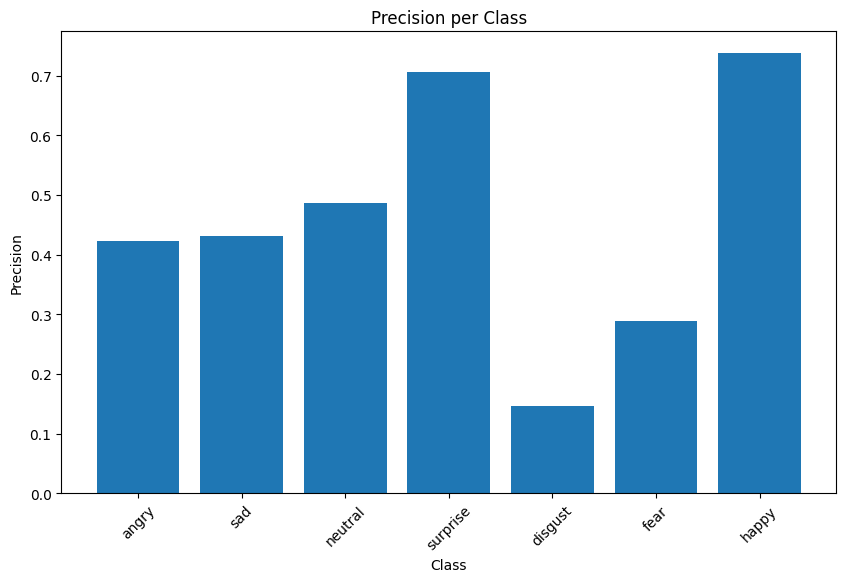

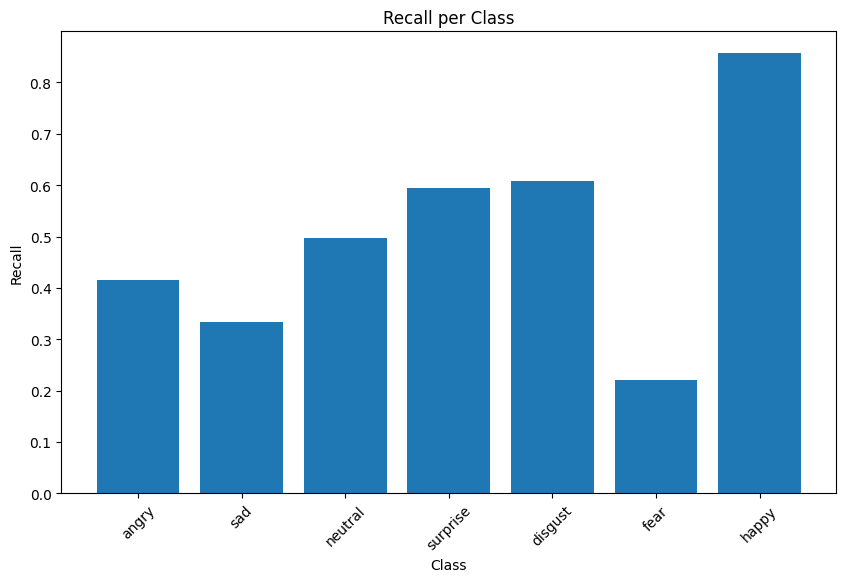

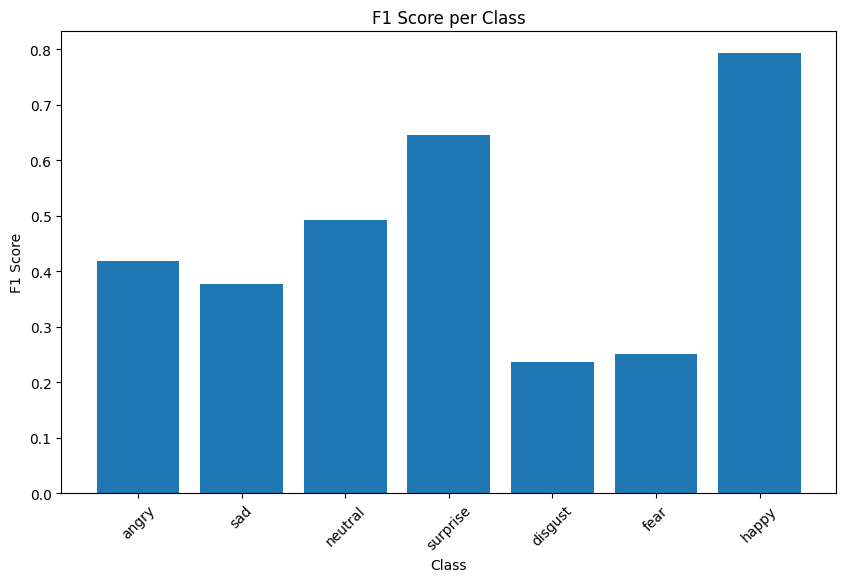

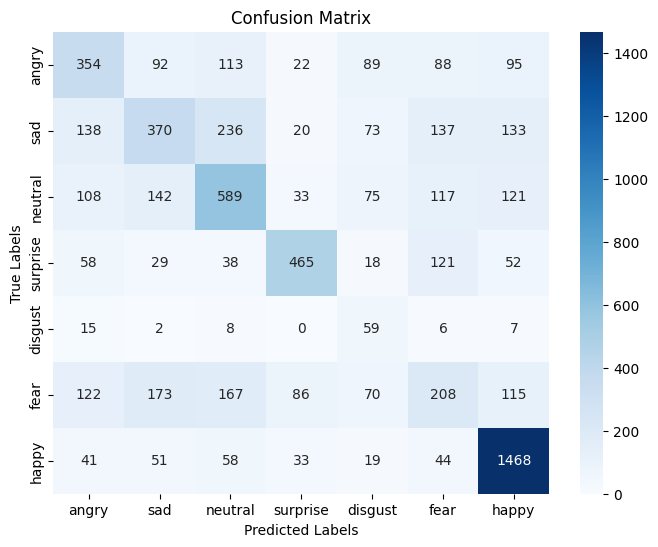

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model = LandmarkCNN()
model.load_state_dict(torch.load("/content/artefatto/best_model.pt"))
model.eval()
model.to(device)



# Calcola le metriche sul test dataset
model.eval()  # Imposta il modello in modalità di valutazione (non addestramento)
test_predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None)
recall = recall_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
#auc_roc = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
classification_rep = classification_report(test_labels, test_predictions)

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
#print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_rep)

# Lista delle etichette delle classi
#class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']
class_labels=[9,9,9,9,9,9,9]
for label in ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]:
  class_labels[label_dict[label]]=label




# Crea il grafico a barre per la precisione
plt.figure(figsize=(10, 6))
plt.bar(class_labels, precision)
plt.title('Precision per Class')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per il recall
plt.figure(figsize=(10, 6))
plt.bar(class_labels, recall)
plt.title('Recall per Class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per l'F1-score
plt.figure(figsize=(10, 6))
plt.bar(class_labels, f1)
plt.title('F1 Score per Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()




# Calcola la matrice di confusione
cm = confusion_matrix(test_labels, test_predictions)

# Crea una figura e un'asse per la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Imposta i nomi delle etichette sulle assi x e y
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Visualizza la matrice di confusione
plt.show()
